# Multivariate time-series analysis with Explainable Boosting Machine (EBM)

Explainable Boosting Machine (EBM) is an interpretable machine learning model that combines the advantages of Generalized Additive Models (GAMs) and gradient boosting . EBM uses techniques like bagging, automatic interaction detection, and cyclic coordinate descent to improve the accuracy and interpretability of GAMs . EBM is developed at Microsoft Research and is included in the InterpretML framework

Data preprocessing:
1. Categorical features have been Encoded
2. Text columns and columns that have no effect on the model have been dropped
3. Added 7 lagged values

Model training:
1. Trained a EBM model using RandomizedSearch and then GridSearchCV, cross-validated by Time Series Split
2. Finalize with data ending on 2023-07-31

Model validation on testing set：
- MAE: 38.18
- MSE: 2646.17
- MAPE: 0.055
- RMSE: 51.44
- R2: 0.360

Model inference:
- Predict August, 2023 and compare with actural target value
- Forecast Sep.， 2023

Explain how the model generates prediction:

1. Intercept of 475 dominates the prediction;
2. In terms of Feature importance, generally, Lagged > Temporal > Weather;
3. Features of target (daily crime count) with 1 to 7 lags can yield from -180 (±20) to 70 (±10);
4. Some temporal features: Yearly trend (gradual increase), Holiday has 44 fewer than non holiday, Friday has 20 more, and Sunday has 16 fewer;
5. Most important weather factor: Solar radiation, sea level pressure, and uv index;
6. Increasing solar radiation first increases and then decreases the target;
7. Increasing temp increases the target nonlinearly;
8. Decreasing visibility increases daily crime count up to 20.

## Import modules

In [1]:
# !pip install interpret --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import deque

from interpret.glassbox import ExplainableBoostingRegressor
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from interpret import show

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,  mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV

import pickle
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.insert(1,'./library')

from create_lag_features import create_lag_features
from prepare_newdata import prepare_newdata

seed = 42

## Load data

In [3]:
w_encoding_file = '../data/Cleaned/encoding_weather_by_dihia_Lanasri.csv'
filename = '../data/Cleaned/daily crime numbers and weather data for time series analysis.csv'

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# w_encoding_file = '/content/drive/MyDrive/Omdena/Houston Local Chapter/Weather&Crime/Data/Cleaned data/encoding_weather_by_dihia_Lanasri.csv'
# filename = '/content/drive/MyDrive/Omdena/Houston Local Chapter/Weather&Crime/Data/Cleaned data/daily crime numbers and weather data for time series analysis.csv'

In [5]:
df = pd.read_csv(filename, parse_dates=['date'])
df.shape

(4991, 74)

In [6]:
w_encoding_df = pd.read_csv(w_encoding_file)
w_encoding_df.shape

(4991, 32)

the column `conditions` in weather data has been encoded to five columns, concatenate weather_encoding_data

In [7]:
df = pd.concat([df, w_encoding_df.loc[:,['Clear', 'Overcast', 'Partiallycloudy', 'Rain', 'Snow']]], axis=1).drop(columns='conditions')

In [8]:
df.set_index('date', inplace=True)

## Target variables: total daily crime number `Offense Count` and numbers of top 6 crime types

In [9]:
targets_df = df.loc[:,'Kidnapping/Abduction':'Offense Count'].copy()
targets_columns = targets_df.sum().T.sort_values(ascending=False).head(7).index

## Feature engineering

In [10]:
# null values
counts = df.isnull().sum()
print(counts.sort_values(ascending=False))

solarradiation                          365
solarenergy                             365
uvindex                                 365
Kidnapping/Abduction                      0
snowdepth                                 0
                                       ... 
Curfew/Loitering/Vagrancy Violations      0
Bad Checks                                0
Homicide Offenses                         0
Animal Cruelty                            0
Snow                                      0
Length: 77, dtype: int64


A full year (2014) worth of data is missing for solarenergy, solarradiation, and uvindex

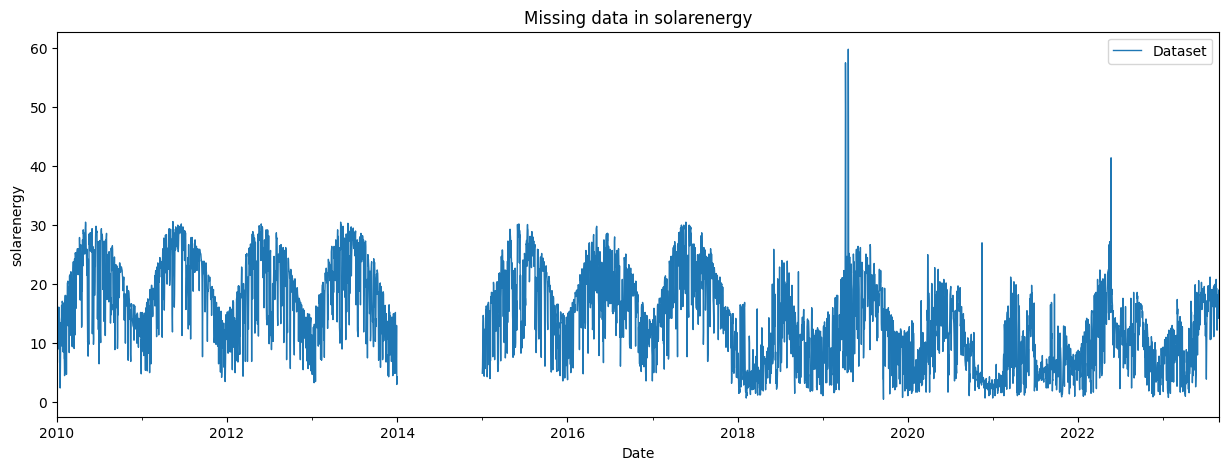

In [11]:
#Visualizing missing solarenergy values
fig, ax = plt.subplots(figsize=(15, 5))

df.plot(y='solarenergy', ax=ax, label='Dataset', title='Missing data in solarenergy', linewidth=1)

plt.xlabel("Date")
plt.ylabel("solarenergy")
plt.show()

In [12]:
# Fill missing data with values from the previous year
df = df.fillna(df.shift(365))

In [13]:
# using sunrise and sunset to create daytime
# Convert them to datetime format
df['sunset'] = pd.to_datetime(df['sunset'], format='%H:%M:%S')
df['sunrise'] = pd.to_datetime(df['sunrise'], format='%H:%M:%S')

# Calculate the time difference between 'sunset' and 'sunrise'
# and extract the daytime interval in seconds for numerical analysis
df['daytime_interval'] = (df['sunset'] - df['sunrise']).dt.total_seconds()


Time series are characterized by the time-related dependenceies between values. To make use of this aspect in our model we will integrate a number of past values of the target variable as input features. We use 7 of the most recent past values as this captures most of the past data information.

In [14]:
for column in ['Offense Count']:
  df = create_lag_features(df, column,lags=7)

Check collinearity features `solarenergy`. Drop it in the pipe.

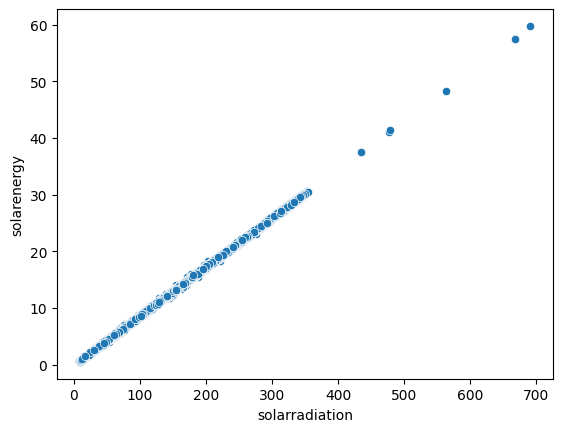

In [15]:
sns.scatterplot(data=df, x='solarradiation',y='solarenergy');

In [16]:
# some weather features to drop
print(df['precipprob'].unique())
print(df['snow'].unique())
print(df['snowdepth'].unique())
print(df['icon'].unique())

[  0 100]
[0.  0.2]
[0.  0.1 0.7 2.3 0.2]
['partly-cloudy-day' 'clear-day' 'rain' 'cloudy' 'wind' 'snow']


- Encode categorical data
- Drop text columns and columns that have no impact on the model

In [17]:
# "OneHotEncode" categorial fetures
def encodeCategoricalFeatures(main_df):
    df = main_df.copy()

    columns = ["week", "season"] # "icon",  "preciptype"

    dummies = pd.get_dummies(df[columns])
    df = pd.concat([df, dummies], axis='columns')

    return df

# drop cols
def dropFeatures(main_df):
    df = main_df.copy()
    df.drop(df.loc[:, :'Offense Count'], axis=1, inplace=True)
    cols = [
        'week',
        'season',
        'icon',
        'mon_year',
        'preciptype',
        'sunrise',
        'sunset',
        'solarenergy',
        'description',
        'stations',
        'snow',
        'snowdepth',
        'precipprob',
    ]
    df.drop(columns=cols, inplace=True)
    return df

In [18]:
df = (df
      .pipe(encodeCategoricalFeatures)
      .pipe(dropFeatures)
)

## Model development
### Train / test split

In [19]:
def prepare_data(df=df, column_name= 'Offense Count'):
  df = df.merge( targets_df[column_name], left_index=True, right_index=True)
  return df

In [20]:
df_all = prepare_data()

Use data before 2023-08-01 for model development and data after that as holdout data

In [21]:
data2308_df = df_all.iloc[4960:].copy()
df_all = df_all.iloc[0:4960].copy()
df_all.tail()

month  year  is_holiday  is_weekend  tempmax  tempmin  temp  \
date                                                                      
2023-07-27      7  2023           0           0     93.2     80.3  86.0   
2023-07-28      7  2023           0           0     95.0     80.2  85.6   
2023-07-29      7  2023           0           1     95.8     80.3  86.2   
2023-07-30      7  2023           0           1     98.4     80.4  87.5   
2023-07-31      7  2023           0           0    100.0     80.5  89.1   

            feelslikemax  feelslikemin  feelslike  ...  week_Saturday  \
date                                               ...                  
2023-07-27          97.3          85.5       91.7  ...          False   
2023-07-28          99.0          84.6       90.4  ...          False   
2023-07-29         100.1          85.3       91.9  ...           True   
2023-07-30         102.9          85.7       94.0  ...          False   
2023-07-31         105.7          86.1       95.5  ...          False   

            week_Sunday  week_Thursday  week_Tuesday  week_Wednesday  \
date                                                                   
2023-07-27        False           True         False           False   
2023-07-28        False          False         False           False   
2023-07-29        False          False         False           False   
2023-07-30         True          False         False           False   
2023-07-31        False          False         False           False   

            season_Autumn  season_Spring  season_Summer  season_Winter  \
date                                                                     
2023-07-27          False          False           True          False   
2023-07-28          False          False           True          False   
2023-07-29          False          False           True          False   
2023-07-30          False          False           True          False   
2023-07-31          False          False           True          False   

            Offense Count  
date                       
2023-07-27            683  
2023-07-28            690  
2023-07-29            693  
2023-07-30            661  
2023-07-31            607  

[5 rows x 48 columns]

In [22]:
data2308_df.to_csv("../data/Cleaned/" + "august_predict_data.csv")

In [23]:
# Split df_final into train and test
df_all.dropna(inplace=True)
num_train = int(len(df_all)*0.8)
train = df_all[:num_train]
test = df_all[num_train:]

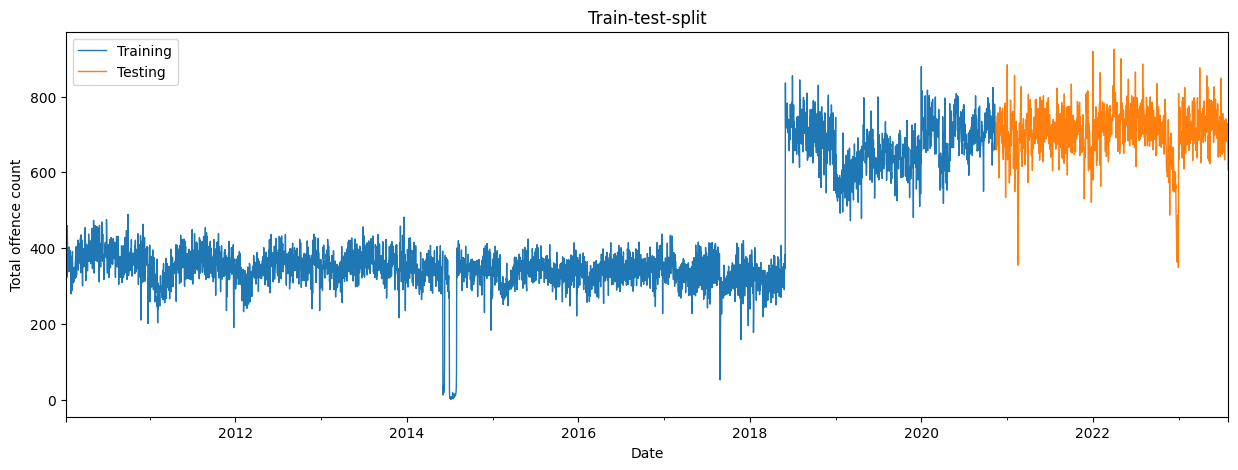

In [24]:
figure, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label="Training", y="Offense Count", linewidth=1)
test.plot(ax=ax, label="Testing", y="Offense Count", linewidth=1)
plt.xlabel("Date")
plt.ylabel("Total offence count")
plt.title('Train-test-split')
plt.show()

In [25]:
X_train = train.drop('Offense Count', axis=1)
y_train = train['Offense Count']

X_test = test.drop('Offense Count', axis=1)
y_test = test['Offense Count']

### EBM

#### Hyperparameter tuning

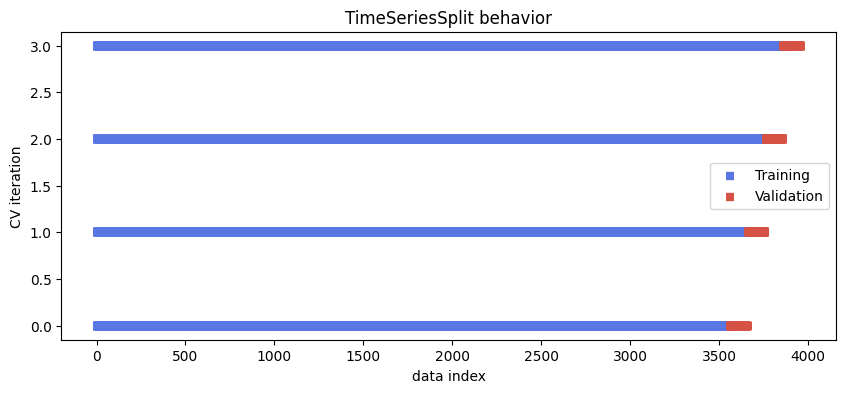

In [25]:
# Create time-series cross-validation object
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)

# Iterate through CV splits
fig, ax = plt.subplots(figsize=(10,4))
for ii, (tr, tt) in enumerate(cv_split.split(X_train, y_train)):
    # plot training and test indices
    l1 = ax.scatter(tr, [ii] * len(tr), c=[plt.cm.coolwarm(.1)], marker='_', lw=6)
    l2 = ax.scatter(tt, [ii] * len(tt), c=[plt.cm.coolwarm(.9)], marker='_', lw=6)
    ax.set(title='TimeSeriesSplit behavior', xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['Training', 'Validation'])
    # Plot the training data on each iteration, to see the behavior of the CV
#     ax.plot(tr, ii + y[tr])

# ax.set(title='Training data on each CV iteration', ylabel='CV iteration')

In [ ]:
# Use Randomized Search to locate the approximate hyperparameters
ebm = ExplainableBoostingRegressor(random_state=seed)
param_grid = {
    'learning_rate': [0.05, 0.1],
    'min_samples_leaf': [2, 3],
    'max_leaves': list(range(2,6)),
    'outer_bags': list(range(8,26)),
    'inner_bags': list(range(0, 26)),
    'max_bins': [32, 64, 128, 256, 512, 1024]
    }
random_ebm = RandomizedSearchCV(
    estimator=ebm,
    param_distributions=param_grid,
    n_iter=60,
    n_jobs=-1,
    cv=cv_split,
    return_train_score=True)
random_ebm.fit(X_train, y_train)

In [28]:
best_params_rn = random_ebm.best_params_
print(best_params_rn)

{'outer_bags': 19, 'min_samples_leaf': 3, 'max_leaves': 2, 'max_bins': 1024, 'learning_rate': 0.05, 'inner_bags': 9}


In [29]:
pd.DataFrame.from_dict(random_ebm.cv_results_).sort_values(by='rank_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
50      84.730152      6.306771         0.012878        0.007389   
21     108.272271     12.022984         0.010648        0.003618   
20      58.661898      4.452233         0.009354        0.000469   
27      44.054096      3.780745         0.016694        0.006744   
26      53.312666      1.948823         0.012210        0.003705   
37      95.058231      4.532069         0.009777        0.001388   
28      63.280673      4.048195         0.011602        0.004866   
25      35.289614      2.531484         0.008844        0.000878   
3      161.556502      7.109808         0.008926        0.000874   
23     173.822477     14.399309         0.008666        0.000466   
55      24.737249      3.001919         0.008596        0.000298   
36      98.464200      6.086615         0.013693        0.004691   
6       48.643436      4.783700         0.014604        0.006735   
11     119.651926      8.610465         0.015057        0.006661   
41      95.155734      7.416001         0.008336        0.000477   
2       65.992350      6.486310         0.017609        0.007967   
45      14.238689      1.299729         0.017938        0.010314   
14     120.552065      6.388481         0.011333        0.004603   
59      76.986239      9.701375         0.009191        0.000875   
0       85.409179      7.551051         0.012806        0.004324   
22      20.497770      2.446928         0.009153        0.000750   
57     212.545306      4.833938         0.013755        0.003059   
17      66.433437      5.836370         0.007980        0.000175   
58       8.537850      1.707189         0.009130        0.000681   
49     123.990658      7.300355         0.013829        0.004806   
32      32.405847      2.351017         0.008487        0.000595   
43      69.541883      2.660319         0.012902        0.004216   
19     134.594650     13.052334         0.012104        0.004286   
35      44.240472      1.711185         0.017343        0.005771   
10     118.015676     10.301684         0.011048        0.005147   
16      77.787364      6.097883         0.009263        0.001659   
5       18.010904      0.780891         0.009360        0.001300   
24     137.862292      7.884448         0.007972        0.000350   
13      27.112350      2.010113         0.014878        0.005382   
18      86.120328      6.863154         0.010667        0.003778   
47      34.232696      2.029089         0.008589        0.000837   
54      50.853595      1.574661         0.008173        0.000545   
44     115.433792     19.929202         0.017459        0.008662   
46     103.867992      6.681101         0.008027        0.000501   
33      39.308092      2.261957         0.008666        0.000988   
7       62.600382      3.765649         0.008325        0.000511   
39     150.088338     14.896337         0.012502        0.003599   
53      93.437664      6.821518         0.008418        0.000518   
40      36.263168      2.524412         0.008408        0.000436   
38      57.286755      2.997251         0.012598        0.004100   
12     125.615381      7.154770         0.011020        0.003789   
8      157.504879      8.493405         0.010633        0.004062   
31      44.831597      3.000501         0.009298        0.000604   
30     102.186853      7.159694         0.008614        0.000626   
56     121.635384      7.156756         0.008649        0.000454   
51     104.193880      7.046883         0.008808        0.000680   
1       64.976548      2.862216         0.008721        0.000656   
29      89.880798      8.124325         0.010771        0.003970   
15      80.343881     12.817714         0.014492        0.006589   
52      85.454052      4.107291         0.008580        0.000532   
42      21.811765      1.815329         0.011002        0.004299   
4       31.978079      0.538313         0.012323        0.005539   
34      31.497812      2.093973         0.008621        0.00

In [27]:
# Grid Search after randomized search locating
ebm = ExplainableBoostingRegressor(random_state=seed)
parameters = {
    'learning_rate': [0.05],
    'min_samples_leaf': [3],
    'max_leaves': [2],
    'outer_bags': list(range(14,21)),
    'inner_bags': list(range(5, 18, 2)),
    'max_bins': [512, 1024]
}

grid_search = GridSearchCV(estimator=ebm, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=ExplainableBoostingRegressor(),
             param_grid={'inner_bags': [5, 7, 9, 11, 13, 15, 17],
                         'learning_rate': [0.05], 'max_bins': [512, 1024],
                         'max_leaves': [2], 'min_samples_leaf': [3],
                         'outer_bags': [14, 15, 16, 17, 18, 19, 20]})

In [28]:
best_params = grid_search.best_params_
print(best_params)

{'inner_bags': 9, 'learning_rate': 0.05, 'max_bins': 1024, 'max_leaves': 2, 'min_samples_leaf': 3, 'outer_bags': 14}


In [30]:
pd.DataFrame.from_dict(grid_search.cv_results_).sort_values(by='rank_test_score').head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
35      36.068744      4.701418         0.007050        0.002017   
68      68.694551      5.067569         0.007683        0.001824   
55      59.848484      4.696463         0.006656        0.001089   
69      73.706292      3.613010         0.009804        0.003745   
96      83.267964      3.701783         0.008090        0.001583   

   param_inner_bags param_learning_rate param_max_bins param_max_leaves  \
35                9                0.05           1024                2   
68               13                0.05           1024                2   
55               11                0.05           1024                2   
69               13                0.05           1024                2   
96               17                0.05           1024                2   

   param_min_samples_leaf param_outer_bags  \
35                      3               14   
68                      3               19   
55                      3               20   
69                      3               20   
96                      3               19   

                                               params  split0_test_score  \
35  {'inner_bags': 9, 'learning_rate': 0.05, 'max_...           0.336438   
68  {'inner_bags': 13, 'learning_rate': 0.05, 'max...           0.354552   
55  {'inner_bags': 11, 'learning_rate': 0.05, 'max...           0.347019   
69  {'inner_bags': 13, 'learning_rate': 0.05, 'max...           0.351481   
96  {'inner_bags': 17, 'learning_rate': 0.05, 'max...           0.347837   

    split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
35           0.302541           0.282736           0.164079         0.271449   
68           0.311866           0.280190           0.125825         0.268108   
55           0.317026           0.282509           0.125609         0.268041   
69           0.315514           0.279527           0.123781         0.267576   
96           0.313634           0.282376           0.119856         0.265926   

    std_test_score  rank_test_score  
35        0.064896                1  
68        0.086281                2  
55        0.085342                3  
69        0.086830                4  
96        0.087454                5

In [26]:
# {'learning_rate': 0.05, 'max_leaves': 2, 'min_samples_leaf': 3}
best_params = {'inner_bags': 9, 'learning_rate': 0.05, 'max_bins': 1024, 'max_leaves': 2, 'min_samples_leaf': 3, 'outer_bags': 14}

In [27]:
ebm = ExplainableBoostingRegressor(random_state=seed)
ebm.set_params(**best_params)
ebm.fit(X_train, y_train)

ExplainableBoostingRegressor(inner_bags=9, learning_rate=0.05, max_bins=1024,
                             max_leaves=2, min_samples_leaf=3, outer_bags=14)

#### Evaluation

In [78]:
def evaluate_model(y_test, pred):
    print(f"MAE: {mean_absolute_error(y_test, pred)}")
    print(f"MSE: {mean_squared_error(y_test, pred)}")
    print(f"MAPE: {mean_absolute_percentage_error(y_test, pred)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
    print(f"R2: {r2_score(y_test,pred)}")

def plot_predictions(model_name, testing_dates, y_test, pred, target):
    df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": pred })
    figure, ax = plt.subplots(figsize=(15, 5))
    df_test.plot(ax=ax, label="Actual", x="date", y="actual", linewidth=2)
    df_test.plot(ax=ax, label="Prediction", x="date", y="prediction", linewidth=2)
    plt.legend(["Actual", "Prediction"], loc='best')
    plt.title(target + " ("+model_name+")")

    return ax

MAE: 38.17878539972068
MSE: 2646.172956825924
MAPE: 0.055206732530653266
RMSE: 51.44096574546325
R2: 0.3603225815153376


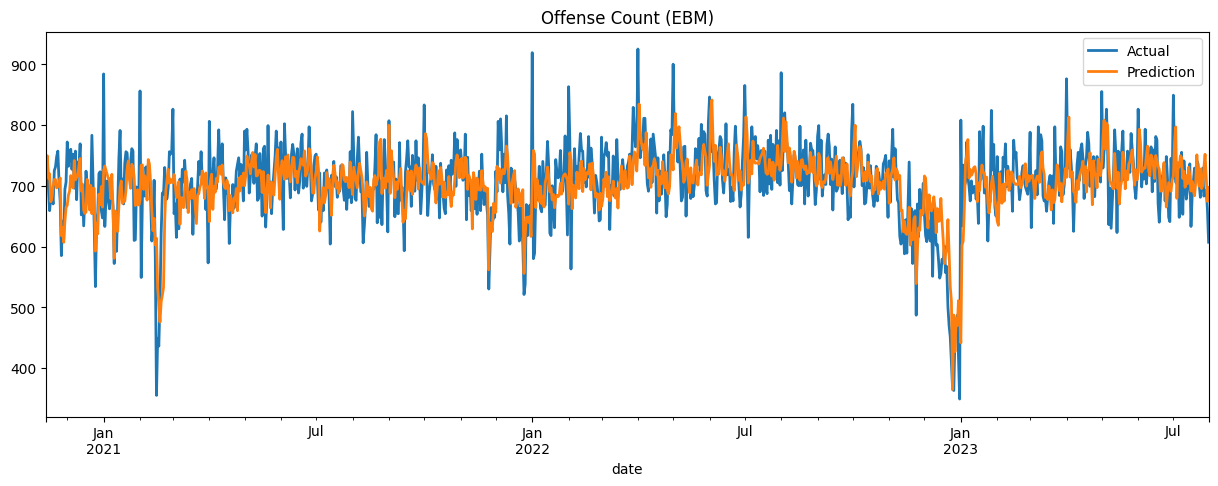

In [32]:
# Evaluating GridSearch results
pred = ebm.predict(X_test)
plot_predictions("EBM", test.index, y_test, pred, y_test.name)
evaluate_model(y_test, pred)

###  Fit top 6 daily specific crime count and explain the model

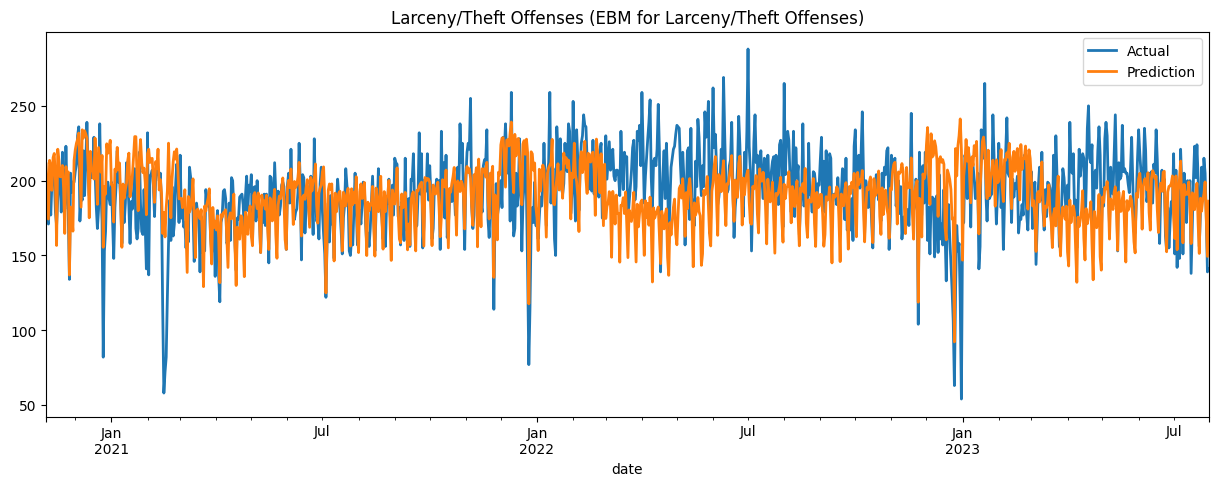

MAE: 20.672111187869568
MSE: 746.952970458085
MAPE: 0.11487560913222249
RMSE: 27.330440363413192
R2: -0.01286742151075071


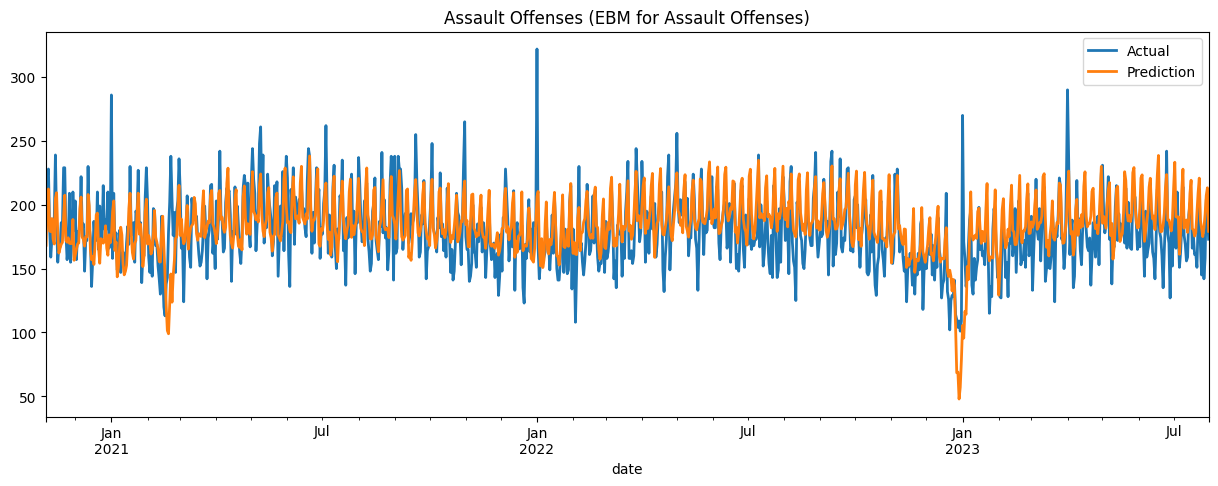

MAE: 18.151915473038564
MSE: 556.6384228199822
MAPE: 0.10626081587717053
RMSE: 23.5931859404359
R2: 0.29201207483776204


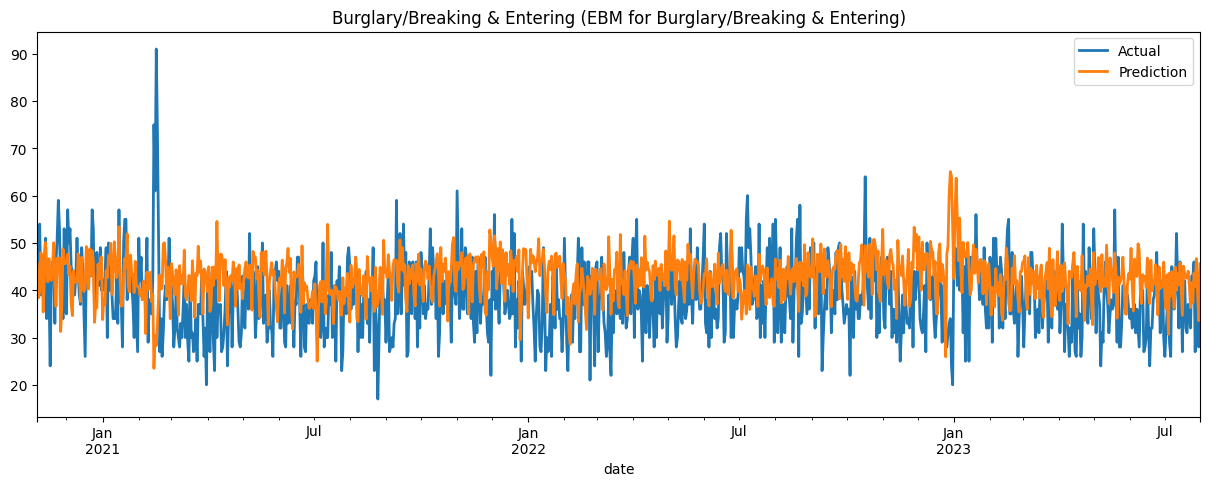

MAE: 7.48284312174176
MSE: 91.32276789017706
MAPE: 0.21730123804580168
RMSE: 9.556294673678552
R2: -0.4995163402638907


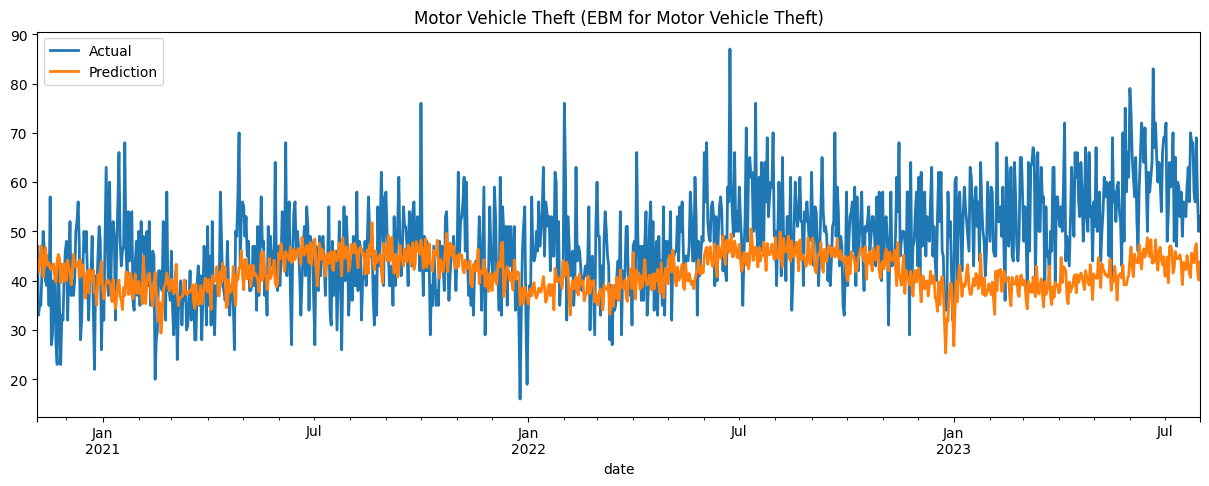

MAE: 9.348591959911937
MSE: 139.78016948015377
MAPE: 0.1871479763672018
RMSE: 11.822866381726293
R2: -0.36608767168108614


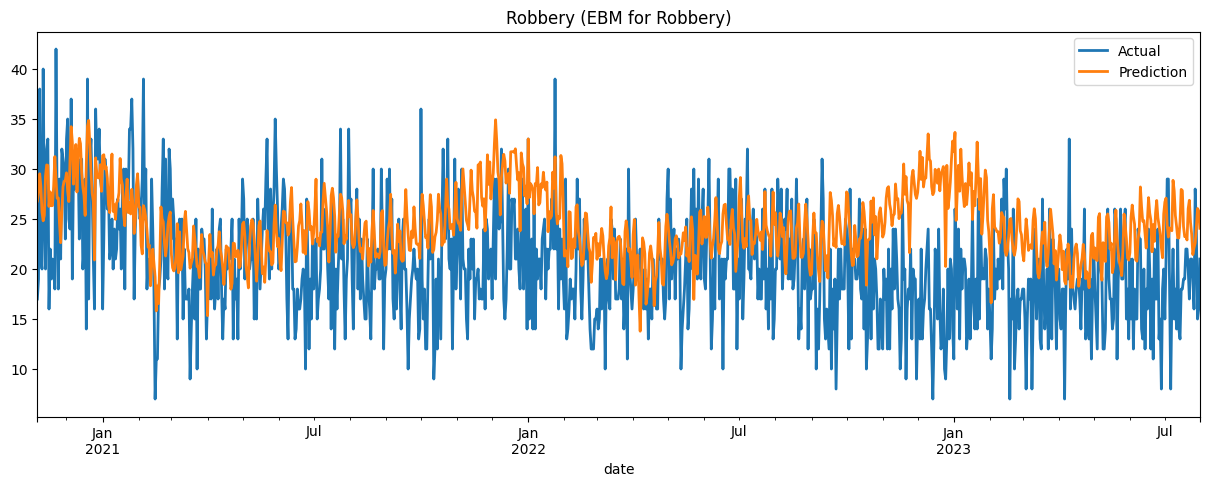

MAE: 5.73805472522745
MSE: 49.515523376411714
MAPE: 0.3494864724772397
RMSE: 7.0367267515807175
R2: -0.582437477677719


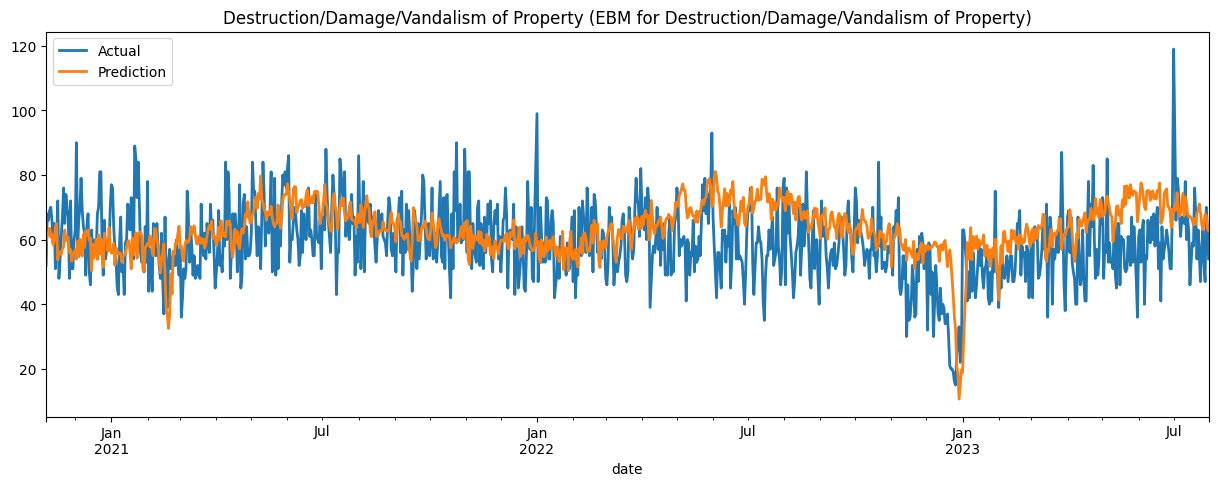

MAE: 9.78203923052218
MSE: 151.14265806673473
MAPE: 0.18511582286901415
RMSE: 12.294009031505334
R2: -0.16758887525474941


In [ ]:
# a dictionary to save model objects
ebm_specific = {}

# iterate over top 6 crime types
for column in targets_columns[1:]:
  # prepare data for model training
  specific_df = prepare_data( column_name= column)

  # train-test-split
  train = specific_df[:num_train]
  test = specific_df[num_train:]
  X_train = train.drop(column, axis=1)
  y_train = train[column]
  X_test = test.drop(column, axis=1)
  y_test = test[column]

  #model training
  ebm_sc = ExplainableBoostingRegressor(random_state=seed)
  ebm_sc.fit(X_train, y_train)
  ebm_specific[column] = ebm_sc

  # Evaluating model results
  pred = ebm_sc.predict(X_test)
  plot_predictions("EBM" + " for "+ column, test.index, y_test, pred, target=column)
  evaluate_model(y_test, pred)

The model for Assault Offenses can explains part of the variance ratio of test date with R^2 of 0.29. The mean absolute error are about 10%. Explain the model below.

#### Explain Assault Offenses model

In [ ]:
ebm_ao_global = ebm_specific['Assault Offenses'].explain_global()
show(ebm_ao_global)

<!-- http://127.0.0.1:7001/2126536906816/ -->

## Retrain a model with the best parameters and all data

In [34]:
ebm_final = ExplainableBoostingRegressor(random_state=seed)
ebm_final.set_params(**best_params)
ebm_final.fit(df_all.drop('Offense Count', axis=1),df_all['Offense Count'])

ExplainableBoostingRegressor(inner_bags=9, learning_rate=0.05, max_bins=1024,
                             max_leaves=2, min_samples_leaf=3, outer_bags=14)

In [36]:
# Save the model and deploy next
model_path = '../model/'
with open(model_path + 'ebm.pkl', 'wb') as f:
    pickle.dump(ebm_final, f)

with open(model_path + 'ebm_Assault_Offenses.pkl', 'wb') as f:
    pickle.dump(ebm_ao, f)

## Model explanation and inference

### Load EBM model

In [61]:
# Load the model
model_path = '../model/'
with open(model_path + 'ebm.pkl', 'rb') as f:
    ebm = pickle.load(f)

### Explain the GlassboxGlassbox models can provide explanations on a both global (overall behavior) and local (individual predictions) level.

Global explanations are useful for understanding what a model finds important, as well as identifying potential flaws in its decision making (i.e. racial bias).


In [62]:
ebm_global = ebm.explain_global()
show(ebm_global)

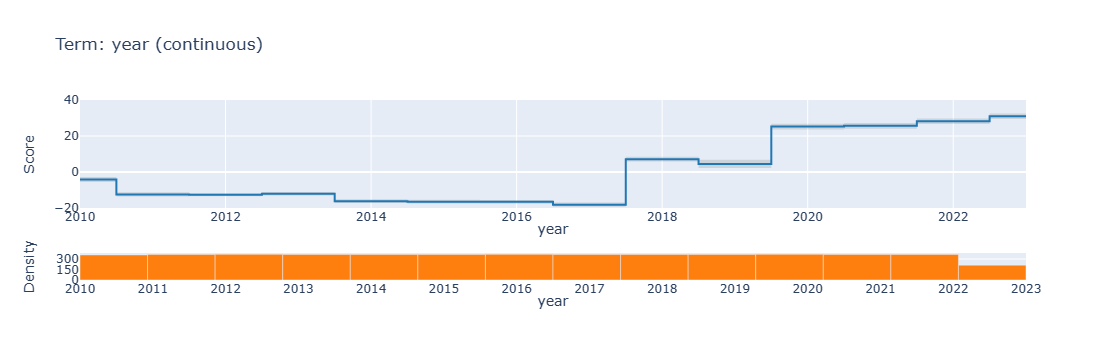

In [71]:
plotly_fig = ebm_global.visualize(1)

plotly_fig['layout']['yaxis']['range'] = [-20, 40]
# plotly_fig['layout']['yaxis2']['range'] = [0, 380]
plotly_fig['layout']['yaxis2']['tickvals'] = [0, 150, 300]
plotly_fig['layout']['xaxis2']['ticktext'] = list(range(2010, 2024))
plotly_fig['layout']['xaxis2']['tickvals'] = list(range(2010, 2024))

plotly_fig

### Prepare data: Weather features in Sep 2023

In [72]:
weatherfile202309 = '../data/Raw/Weather data/Houston,TX 2023-09-01 to 2023-09-30.csv'
weather2309_df = pd.read_csv(weatherfile202309)

In [73]:
data2309_df = prepare_newdata(weather2309_df)

Reorder the column sequences:

In [74]:
# create columns
data2309_df[[column for column in df_all.columns if column not in data2309_df.columns]] = np.nan

# reorder columns
data2309_df = data2309_df[[column for column in df_all.columns]]

Data of 2023-08 is complete, but data of 2023-09 does not have crime count and the lag_features

In [75]:
data2308_09_df = pd.concat([data2308_df, data2309_df], axis=0)
data2308_09_df.isnull().sum().sort_values(ascending=False).head(10)

Offense Count          30
lag_1_Offense Count    30
lag_2_Offense Count    30
lag_3_Offense Count    30
lag_4_Offense Count    30
lag_5_Offense Count    30
lag_6_Offense Count    30
lag_7_Offense Count    30
year                    0
Rain                    0
dtype: int64

### Forecast 08/01/2023 to 09/30/2023 Crime counts:

#### Using realistic crime counts in August as lag features

In [76]:
X_data2308 = data2308_df.drop('Offense Count', axis=1)
y_data2308 = data2308_df['Offense Count']

MAE: 38.270472921596976
MSE: 2125.995052617046
MAPE: 0.05919323110839977
RMSE: 46.10851388428222
R2: -0.056595284537594326


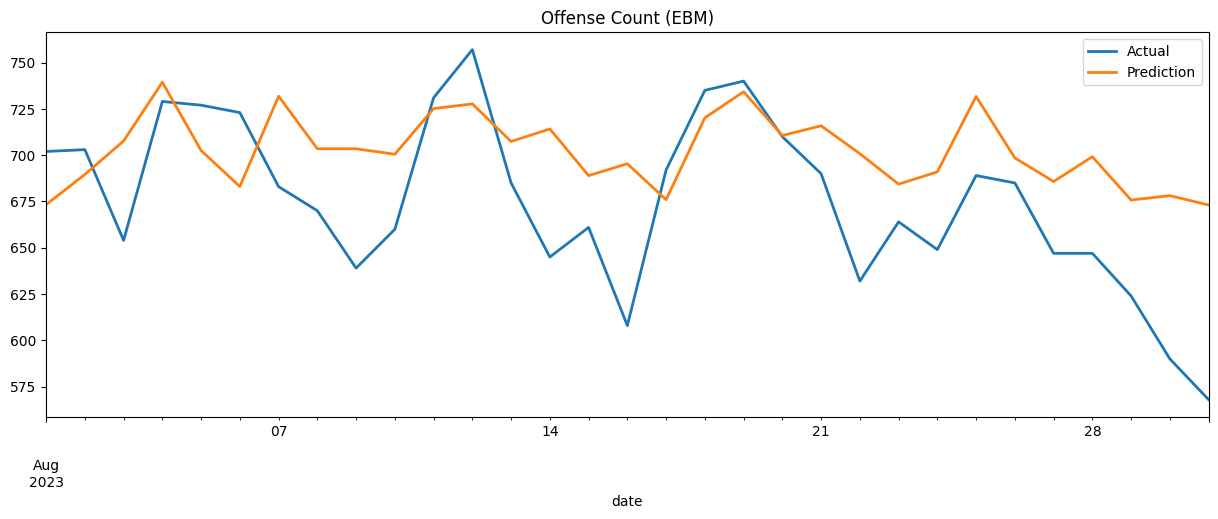

In [79]:
pred = ebm.predict(X_data2308)
plot_predictions("EBM", X_data2308.index, y_data2308, pred, y_data2308.name)
evaluate_model(y_data2308, pred)

Local explanations show how a single prediction is made. For glassbox models, these explanations are exact – they perfectly describe how the model made its decision.

These explanations are useful for describing to end users which factors were most influential for a prediction.

In [80]:
ebm_local = ebm.explain_local(X_data2308, y_data2308)
show(ebm_local, 0)

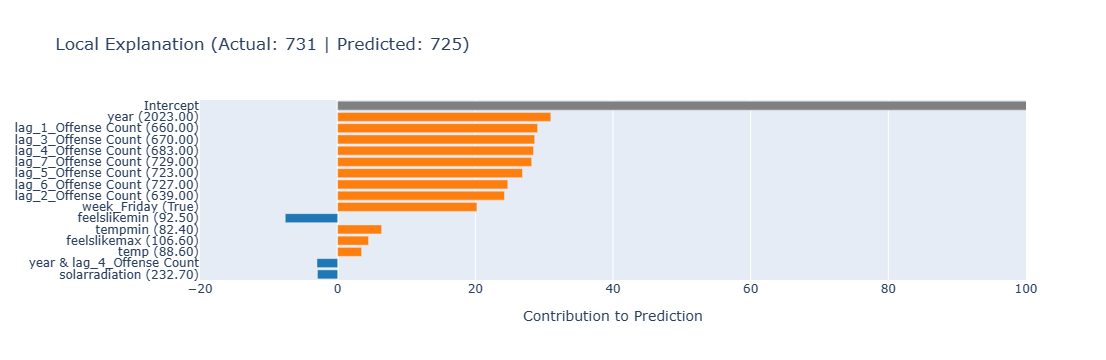

In [84]:
plotly_fig = ebm_local.visualize(10)

plotly_fig['layout']['xaxis']['range'] = [-20, 100]
plotly_fig

#### Incrementally using forecasted crime counts as lag features

In [34]:
column_name = 'Offense Count'
lags = 7
lag_feature_names = list(data2308_09_df[[column for column in data2308_09_df.columns if column_name in column]].columns)
lag_feature_names.pop()
queue = deque(data2308_df.tail(7)[column_name].to_list()[::-1])

for idx, series in data2309_df.iterrows():
    data2309_df.loc[idx, lag_feature_names] = queue
    res = int(np.round(ebm.predict(data2309_df.loc[[idx]].drop(column_name, axis=1))))
    data2309_df.loc[idx, column_name] = res
    queue.appendleft(res)
    queue.pop()

# data2309_df[[column for column in new_temp.columns if column_name in column]]

In [35]:
data2309_df.to_csv("../data/Cleaned/" + "predicted_september_crime.csv")

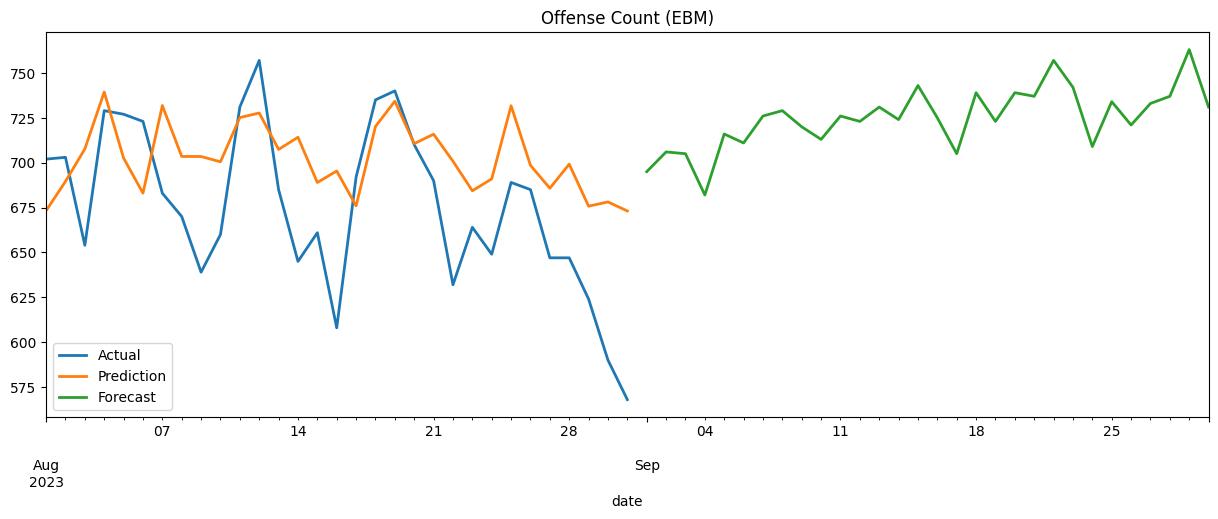

In [47]:
ax = plot_predictions("EBM", X_data2308.index, y_data2308, pred, y_data2308.name)
data2309_df.plot(ax=ax, label="Forecast", y="Offense Count", linewidth=2);
